In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import operator
# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import file_utils    
import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [96]:
summary_team_file = '../Data/sr_summaries_kaggle_id_no_opp_2018.csv'
team_meta_data_file = '../Data/D1_teams.csv'
tournament_data_file = '../Data/tournament_results_2018.csv'
rankings_data_file = '../data/massey_seasons_with_id.csv'

feature_dictionary = utils.Feature_Dictionary()

In [97]:
def recode_tourney_data(tourney_data):
    tourney_data['game_result'] = 1
    tourney_data.game_result = tourney_data.game_result.astype(int)
    tourney_data.rename(columns={"win_seed": "team_seed", "win_market": "team", "win_team_id": "team_id"}, inplace=True)
    tourney_data.rename(columns={"lose_seed": "opp_team_seed", "lose_market": "opp_team",
                                 "lose_team_id": "opp_team_id"}, inplace=True)

    tourney_data['start_season'] = tourney_data['season'] - 1

    # create some temporary buffer columns
    tourney_data['copy_team'] = tourney_data['team']
    tourney_data['copy_team_seed'] = tourney_data['team_seed']
    tourney_data['copy_team_id'] = tourney_data['team_id']

    # swap the team and opp team data
    tourney_data.loc[1::2, 'team'] = tourney_data.loc[1::2, 'opp_team']
    tourney_data.loc[1::2, 'opp_team'] = tourney_data.loc[1::2, 'copy_team']
    tourney_data.loc[1::2, 'team_seed'] = tourney_data.loc[1::2, 'opp_team_seed']
    tourney_data.loc[1::2, 'opp_team_seed'] = tourney_data.loc[1::2, 'copy_team_seed']
    tourney_data.loc[1::2, 'team_id'] = tourney_data.loc[1::2, 'opp_team_id']
    tourney_data.loc[1::2, 'opp_team_id'] = tourney_data.loc[1::2, 'copy_team_id']

    # flip the game result
    tourney_data.loc[1::2, 'game_result'] = 0

    # drop the temporary columns
    tourney_data.drop(columns=['copy_team', 'copy_team_seed', 'copy_team_id'], inplace=True)
    tourney_data.rename(columns={"team_seed": "seed_t", "opp_team_seed": "seed_o"}, inplace=True)

    tourney_data['Game Result'] = tourney_data.game_result.map({1: 'Win', 0: 'Lose'})

    return tourney_data

In [98]:
def merge_tourney_summary_data(tourney_data, summary_data):
    tourney_data = tourney_data.merge(summary_data, left_on=['start_season', 'team_id'],
                                      right_on=['season', 'team_id'], how='left', suffixes=('', '_y'))

    tourney_data.drop(columns=['season_y'], inplace=True)
    tourney_data = tourney_data.merge(summary_data, left_on=['start_season', 'opp_team_id'],
                                      right_on=['season', 'team_id'], how='left', suffixes=('_t', '_o'))

    tourney_data.drop(columns=['school_t', 'school_o', 'games_t', 'games_o', 'team_id_o'], inplace=True)

    return tourney_data

In [99]:
def join_tourney_team_data(tourney_data, teams):
    tourney_data = tourney_data.join(teams, on='team_id_t', how='left')
    tourney_data = tourney_data.join(teams, on='opp_team_id', how='left', lsuffix='_t', rsuffix='_o')
    tourney_data.rename(index=str, columns={'team': 'team_t', 'opp_team': 'team_o', 'opp_team_id': 'team_id_o'},
                        inplace=True)

    tourney_data['game_result'] = tourney_data.game_result.apply(utils.negate_loser)
    return tourney_data

In [100]:
def merge_tourney_ranking_data(tourney_data, computer_rankings):
    temp_merge = tourney_data.merge(computer_rankings, left_on=['season_t', 'team_id_t'],
                                    right_on=['season', 'kaggle_id'], how='left', suffixes=('', '_y'))

    temp_merge.drop(columns=['Team', 'season', 'win_pct', 'kaggle_id'], inplace=True)
    tourney_comp_ratings = temp_merge.merge(computer_rankings, left_on=['season_t', 'team_id_o'],
                                            right_on=['season', 'kaggle_id'], how='left', suffixes=('_t', '_o'))

    tourney_comp_ratings.drop(columns=['Team', 'season', 'win_pct', 'kaggle_id'], inplace=True)

    tourney_comp_ratings.rename(str.lower, axis='columns', inplace=True)
    return tourney_comp_ratings

In [101]:
def compute_delta_features(tourney_comp_ratings):
    tourney_comp_ratings['margin_victory_avg_t'] = tourney_comp_ratings['pts_avg_t'] - tourney_comp_ratings[
        'opp_pts_avg_t']
    tourney_comp_ratings['margin_victory_avg_o'] = tourney_comp_ratings['pts_avg_o'] - tourney_comp_ratings[
        'opp_pts_avg_o']

    tourney_comp_ratings['delta_margin_victory_avg'] = \
        tourney_comp_ratings['margin_victory_avg_t'] - tourney_comp_ratings['margin_victory_avg_o']

    tourney_comp_ratings['delta_fg_pct'] = tourney_comp_ratings['fg_pct_t'] - tourney_comp_ratings['fg_pct_o']

    tourney_comp_ratings['delta_off_rebs_avg'] = tourney_comp_ratings['off_rebs_avg_t'] - tourney_comp_ratings[
        'off_rebs_avg_o']

    tourney_comp_ratings['delta_def_rebs_avg'] = tourney_comp_ratings['def_rebs_avg_t'] - tourney_comp_ratings[
        'def_rebs_avg_o']

    tourney_comp_ratings['delta_ft_pct'] = tourney_comp_ratings['ft_pct_t'] - tourney_comp_ratings['ft_pct_o']

    tourney_comp_ratings['to_net_avg_t'] = tourney_comp_ratings['to_avg_t'] - tourney_comp_ratings['steal_avg_t']

    tourney_comp_ratings['to_net_avg_o'] = tourney_comp_ratings['to_avg_o'] - tourney_comp_ratings['steal_avg_o']

    tourney_comp_ratings['delta_to_net_avg'] = tourney_comp_ratings['to_net_avg_t'] - tourney_comp_ratings[
        'to_net_avg_o']

    tourney_comp_ratings['delta_win_pct'] = tourney_comp_ratings['win_pct_t'] - tourney_comp_ratings['win_pct_o']

    tourney_comp_ratings['delta_off_rating'] = tourney_comp_ratings['off_rating_t'] - tourney_comp_ratings[
        'off_rating_o']

    tourney_comp_ratings['delta_ft_att_avg'] = tourney_comp_ratings['ft_att_avg_t'] - tourney_comp_ratings[
        'ft_att_avg_o']

    tourney_comp_ratings['delta_seed'] = tourney_comp_ratings['seed_t'] - tourney_comp_ratings['seed_o']

    tourney_comp_ratings['delta_srs'] = tourney_comp_ratings['srs_t'] - tourney_comp_ratings['srs_o']
    tourney_comp_ratings['delta_sos'] = tourney_comp_ratings['sos_t'] - tourney_comp_ratings['sos_o']

    tourney_comp_ratings['delta_sag'] = tourney_comp_ratings['sag_t'] - tourney_comp_ratings['sag_o']
    tourney_comp_ratings['delta_wlk'] = tourney_comp_ratings['wlk_t'] - tourney_comp_ratings['wlk_o']
    tourney_comp_ratings['delta_wol'] = tourney_comp_ratings['wol_t'] - tourney_comp_ratings['wol_o']
    tourney_comp_ratings['delta_rth'] = tourney_comp_ratings['rth_t'] - tourney_comp_ratings['rth_o']
    tourney_comp_ratings['delta_col'] = tourney_comp_ratings['col_t'] - tourney_comp_ratings['col_o']
    tourney_comp_ratings['delta_pom'] = tourney_comp_ratings['pom_t'] - tourney_comp_ratings['pom_o']
    tourney_comp_ratings['delta_dol'] = tourney_comp_ratings['dol_t'] - tourney_comp_ratings['dol_o']
    tourney_comp_ratings['delta_rpi'] = tourney_comp_ratings['rpi_t'] - tourney_comp_ratings['rpi_o']
    tourney_comp_ratings['delta_mor'] = tourney_comp_ratings['mor_t'] - tourney_comp_ratings['mor_o']

    tourney_comp_ratings.drop(columns=['season_o'], inplace=True)
    tourney_comp_ratings.dropna(inplace=True)
    return tourney_comp_ratings

In [102]:
def eliminate_features_logistic_regression(classifier, X, y ):
    iteration = 0
    print("Iteration= ", iteration)
    iteration += 1
    model_stats = {}
    drop_list = []
    # get baseline by identifying sorted important features using all of the provided features
    model_stats = utils.save_model_stats(classifier,X,y,model_stats)
    important_features = utils.display_important_features(classifier.coef_[0], X,0)
    #important_features = display_important_features_regression(classifier, X,0)
    # least important feature
    least_important_label = important_features[-1][0]
    print("least_important label= ", least_important_label)
    
    drop_list.append(least_important_label)
    del important_features[-1]
    
    # drop list contains all of the feature labels except for the feature label identified as being most important
    list_count = len(important_features)
    while list_count > 0:
        print("Iteration= ", iteration)
        iteration += 1
        model_stats = utils.save_model_stats(classifier,X.drop(columns=drop_list),y,model_stats)
        least_important_label = important_features[-1][0]
        print("least_important label= ", least_important_label)
        drop_list.append(least_important_label)
        del important_features[-1]
        list_count-=1
    return model_stats

In [103]:
# earliest season data starts in 2000 corresponding to tournament season date of 2001
start_tournament = 2003
stop_tournament = 2017

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

#### Read table of team names and associated team meta data from the Kaggle data set.
https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [104]:
summary_data = file_utils.read_summary_team_data(summary_team_file)
teams = file_utils.read_team_meta_data(team_meta_data_file)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [105]:
tourney_data = file_utils.read_tournament_results(tournament_data_file,start_tournament)
game_data = utils.compute_game_data(tourney_data, teams)
computer_rankings = pd.read_csv(Path(rankings_data_file))
computer_rankings = computer_rankings[computer_rankings['season'] >= start_tournament]


In [106]:
tourney_data = recode_tourney_data(tourney_data)
tourney_data = merge_tourney_summary_data(tourney_data, summary_data)
tourney_data = join_tourney_team_data(tourney_data, teams)

In [107]:
tourney_comp_ratings = merge_tourney_ranking_data(tourney_data, computer_rankings)
tourney_comp_ratings = utils.implement_top_conference_feature(tourney_data, teams, game_data, tourney_comp_ratings)
tourney_comp_ratings = utils.implement_seed_threshold_feature(tourney_comp_ratings)
tourney_comp_ratings = compute_delta_features(tourney_comp_ratings)

In [108]:
tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor


In [109]:
numeric_feature_to_scale = ['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg',
                            'delta_def_rebs_avg', 'delta_ft_pct',
                            'delta_to_net_avg', 'delta_win_pct', 'delta_off_rating',
                            'delta_ft_att_avg',
                            'delta_seed', 'delta_srs', 'delta_sos',
                            'delta_sag', 'delta_wlk', 'delta_wol',
                            'delta_rth', 'delta_col', 'delta_pom',
                            'delta_dol', 'delta_rpi', 'delta_mor']

scaler =StandardScaler()
tourney_comp_ratings[numeric_feature_to_scale] = scaler.fit_transform(tourney_comp_ratings[numeric_feature_to_scale])
tourney_comp_ratings.head()

C:\Users\CHIPK\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\CHIPK\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2003,64,2003-03-21 00:00:00.0000000,8,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,60,9,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,58,-1,2002,Lose,14.05,6.11,0.697,81.0,73.0,0.458,0.774,85.363636,11.0,24.0,15.0,7.0,94.888179,20.0,11.00,5.25,0.758,66.0,60.0,0.451,0.711,71.333333,10.0,23.0,12.0,4.0,92.523364,18.0,Pacific 12,Pacific 12,30,43.0,33,36,32.0,42.0,29.0,50.0,27,38,31.0,25,34,20.0,37.0,33.0,16.0,66,0,0,0,8.0,6.0,0.346694,0.240524,0.410802,0.429263,1.259163,8.0,8.0,0.033305,-0.428353,0.367769,0.564274,-0.166349,0.296388,0.141456,-0.145034,0.158184,0.100632,-0.002273,0.166047,0.047449,-0.087067,0.572446,-0.556750
1,2003,64,2003-03-21 00:00:00.0000000,2,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,85,15,Sam Houston State,67322042-9c40-4dc2-b33a-4754c02ec82a,55,1,2002,Win,18.54,7.76,0.758,75.0,64.0,0.476,0.703,76.945455,10.0,24.0,13.0,7.0,97.471645,18.0,-1.65,-6.87,0.767,72.0,65.0,0.459,0.705,79.620000,11.0,25.0,15.0,8.0,90.429540,23.0,Southeastern,Southland,7,11.0,11,10,14.0,6.0,8.0,15.0,7,138,102.0,115,143,87.0,134.0,93.0,91.0,169,1,0,1,11.0,7.0,0.673971,0.556288,-0.376883,-0.354283,-0.024608,6.0,7.0,-0.366740,-0.048685,1.092534,-1.365443,-1.774689,1.841726,2.142615,-1.915064,-1.447144,-1.716111,-1.834885,-1.220930,-1.874068,-1.352485,-1.355216,-2.239608
2,2003,32,2003-03-23 00:00:00.0000000,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,68,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,62,-1,2002,Lose,16.96,6.96,0.806,77.0,67.0,0.453,0.752,83.167742,14.0,26.0,15.0,6.0,92.583973,26.0,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,Atlantic Coast,Southeastern,9,9.0,4,7,8.0,12.0,4.0,7.0,20,43,47.0,40,40,44.0,45.0,43.0,36.0,44,0,0,1,10.0,5.0,0.837609,-0.359427,0.804645,1.212810,1.831922,9.0,8.0,0.433351,1.177935,0.713928,1.666970,-1.104547,0.407285,-0.184078,-0.519187,-0.621102,-0.613088,-0.477395,-0.617187,-0.501556,-0.633853,-0.531578,-0.351523
3,2003,64,2003-03-21 00:00:00.0000000,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,65,7,Saint Joseph's (PA),f9e4261e-d11d-46c4-bd33-c7bbc94ef0e8,63,1,2002,Win,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,14.61,3.71,0.767,70.0,59.0,0.443,0.686,75.666667,11.0,24.0,12.0,7.0,92.511013,20.0,Southeastern,Atlantic 10,43,47.0,40,40,44.0,45.0,43.0,36.0,44,20,16.0,27,28,27.0,18.0,22.0,27.0,38,1,0,0,5.0,11.0,-0.962413,0.714170,0.410802,-0.354283,-0.498615,8.0,5.0,1.233442,-0.859130,-0.699959,0.012926,0.369764,-0.152607,0.689340,0.301071,0.454312,0.181736,0.133476,0.247634,0.365294,0.303494,0.134341,0.058930
4,2003,4,2003-04-05 00:00:00.0000000,1,Texas,6ed15092-2670-450a-99c2-61d861e87644,95,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,84,-1,2002,Lose,18.91,9.27,0.788,79.0,69.0,0.446,0.721,85.248485,16.0,25.0,13.0,6.0,92.670269,24.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,Big 12,Atlantic Coast,5,7.0,7,6,4.0,7.0,7.0,4.0,12,12,14.0,5,12,9.0,15.0,5.0,9.0,21,0,0,0,10.0,10.0,0.019417,-0.896225,1.198488,-0.746056,0.548152,7.0,6.0,0.433351,-0.4867

In [110]:
feature_data = tourney_comp_ratings.drop(columns=['round','game_date','seed_t','team_t','team_id_t','team_id_o',
                                         'team_o','seed_o','team_id_o','game_result','start_season','game result',
                                         'conf_name_t','conf_name_o']).copy()


feature_data.head()

,season_t,win_pts,lose_pts,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2003,60,58,14.05,6.11,0.697,81.0,73.0,0.458,0.774,85.363636,11.0,24.0,15.0,7.0,94.888179,20.0,11.00,5.25,0.758,66.0,60.0,0.451,0.711,71.333333,10.0,23.0,12.0,4.0,92.523364,18.0,30,43.0,33,36,32.0,42.0,29.0,50.0,27,38,31.0,25,34,20.0,37.0,33.0,16.0,66,0,0,0,8.0,6.0,0.346694,0.240524,0.410802,0.429263,1.259163,8.0,8.0,0.033305,-0.428353,0.367769,0.564274,-0.166349,0.296388,0.141456,-0.145034,0.158184,0.100632,-0.002273,0.166047,0.047449,-0.087067,0.572446,-0.556750
1,2003,85,55,18.54,7.76,0.758,75.0,64.0,0.476,0.703,76.945455,10.0,24.0,13.0,7.0,97.471645,18.0,-1.65,-6.87,0.767,72.0,65.0,0.459,0.705,79.620000,11.0,25.0,15.0,8.0,90.429540,23.0,7,11.0,11,10,14.0,6.0,8.0,15.0,7,138,102.0,115,143,87.0,134.0,93.0,91.0,169,1,0,1,11.0,7.0,0.673971,0.556288,-0.376883,-0.354283,-0.024608,6.0,7.0,-0.366740,-0.048685,1.092534,-1.365443,-1.774689,1.841726,2.142615,-1.915064,-1.447144,-1.716111,-1.834885,-1.220930,-1.874068,-1.352485,-1.355216,-2.239608
2,2003,68,62,16.96,6.96,0.806,77.0,67.0,0.453,0.752,83.167742,14.0,26.0,15.0,6.0,92.583973,26.0,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,9,9.0,4,7,8.0,12.0,4.0,7.0,20,43,47.0,40,40,44.0,45.0,43.0,36.0,44,0,0,1,10.0,5.0,0.837609,-0.359427,0.804645,1.212810,1.831922,9.0,8.0,0.433351,1.177935,0.713928,1.666970,-1.104547,0.407285,-0.184078,-0.519187,-0.621102,-0.613088,-0.477395,-0.617187,-0.501556,-0.633853,-0.531578,-0.351523
3,2003,65,63,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,14.61,3.71,0.767,70.0,59.0,0.443,0.686,75.666667,11.0,24.0,12.0,7.0,92.511013,20.0,43,47.0,40,40,44.0,45.0,43.0,36.0,44,20,16.0,27,28,27.0,18.0,22.0,27.0,38,1,0,0,5.0,11.0,-0.962413,0.714170,0.410802,-0.354283,-0.498615,8.0,5.0,1.233442,-0.859130,-0.699959,0.012926,0.369764,-0.152607,0.689340,0.301071,0.454312,0.181736,0.133476,0.247634,0.365294,0.303494,0.134341,0.058930
4,2003,95,84,18.91,9.27,0.788,79.0,69.0,0.446,0.721,85.248485,16.0,25.0,13.0,6.0,92.670269,24.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,5,7.0,7,6,4.0,7.0,7.0,4.0,12,12,14.0,5,12,9.0,15.0,5.0,9.0,21,0,0,0,10.0,10.0,0.019417,-0.896225,1.198488,-0.746056,0.548152,7.0,6.0,0.433351,-0.486763,-0.101901,0.288600,-0.300377,0.011484,0.052806,-0.130644,-0.137945,0.003306,-0.110873,-0.111348,-0.140369,0.006668,-0.110998,-0.146297


In [111]:
feature_data.drop(columns=['pts_avg_t','pts_avg_o', 'opp_pts_avg_t','opp_pts_avg_o',
                                'margin_victory_avg_t', 'margin_victory_avg_o',
                                'poss_avg_t','poss_avg_o',
                                'fg_pct_t','fg_pct_o',
                                'off_rebs_avg_t','off_rebs_avg_o','def_rebs_avg_t','def_rebs_avg_o',
                                'ft_pct_t','ft_pct_o',
                                'to_avg_t','to_avg_o','steal_avg_t','steal_avg_o',
                                'to_net_avg_t','to_net_avg_o',
                                'win_pct_t','win_pct_o','off_rating_t','off_rating_o',
                                'ft_att_avg_t','ft_att_avg_o','opp_pts_avg_t','opp_pts_avg_o',
                                'srs_t','srs_o','sos_t','sos_o',
                                'sag_t','sag_o','wlk_t','wlk_o','wol_t','wol_o',
                                'rth_t','rth_o','col_t','col_o','pom_t','pom_o',
                                'dol_t','dol_o','rpi_t','rpi_o','mor_t','mor_o'], inplace=True)


# for now drop the delta seed features
feature_data.drop(columns=['upset_seed_threshold'], inplace=True)
feature_data.head(50)

,season_t,win_pts,lose_pts,top_conf_t,top_conf_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2003,60,58,0,0,0.346694,0.240524,0.410802,0.429263,1.259163,0.033305,-0.428353,0.367769,0.564274,-0.166349,0.296388,0.141456,-0.145034,0.158184,0.100632,-0.002273,0.166047,0.047449,-0.087067,0.572446,-0.556750
1,2003,85,55,1,0,0.673971,0.556288,-0.376883,-0.354283,-0.024608,-0.366740,-0.048685,1.092534,-1.365443,-1.774689,1.841726,2.142615,-1.915064,-1.447144,-1.716111,-1.834885,-1.220930,-1.874068,-1.352485,-1.355216,-2.239608
2,2003,68,62,0,0,0.837609,-0.359427,0.804645,1.212810,1.831922,0.433351,1.177935,0.713928,1.666970,-1.104547,0.407285,-0.184078,-0.519187,-0.621102,-0.613088,-0.477395,-0.617187,-0.501556,-0.633853,-0.531578,-0.351523
3,2003,65,63,1,0,-0.962413,0.714170,0.410802,-0.354283,-0.498615,1.233442,-0.859130,-0.699959,0.012926,0.369764,-0.152607,0.689340,0.301071,0.454312,0.181736,0.133476,0.247634,0.365294,0.303494,0.134341,0.058930
4,2003,95,84,0,0,0.019417,-0.896225,1.198488,-0.746056,0.548152,0.433351,-0.486763,-0.101901,0.288600,-0.300377,0.011484,0.052806,-0.130644,-0.137945,0.003306,-0.110873,-0.111348,-0.140369,0.006668,-0.110998,-0.146297
5,2003,79,78,0,0,0.837609,0.335253,0.410802,1.604583,0.686404,-0.766786,1.550301,0.830533,0.839948,-0.970519,0.593014,0.115297,-0.476015,-0.543173,-0.596868,-0.409520,-0.600870,-0.458214,-0.618230,-0.496530,-0.337842
6,2003,81,78,0,0,1.001247,0.619440,0.410802,0.037490,-0.735619,-0.366740,-0.479462,0.093141,0.012926,-0.166349,0.560556,0.235919,-0.145034,-0.184702,0.084411,-0.124447,-0.062396,-0.183711,0.069157,-0.075949,-0.283115
7,2003,76,65,1,0,0.510332,0.903628,0.804645,1.604583,-1.841637,0.433351,0.674145,0.160160,0.012926,-1.506632,1.215116,1.616530,-0.850168,-0.558759,-0.953728,-0.911792,-0.731409,-0.718269,-0.836944,-0.829490,-0.939840
8,2003,68,56,0,0,-0.471498,-0.833072,-0.376883,-1.137829,-0.854121,0.033305,-1.216894,-1.021145,-0.262748,0.369764,-0.375302,-0.064909,0.157166,0.111427,0.279062,0.160626,0.247634,0.177476,0.319116,0.204438,0.086293
9,2003,63,47,0,0,0.019417,0.935204,0.410802,1.212810,0.034643,0.033305,0.477009,0.145568,1.391296,0.235736,0.035827,0.087685,0.027652,0.064669,-0.045356,0.011302,0.068143,0.061896,-0.040200,0.081768,0.182066


In [66]:
X= feature_data[feature_data['season_t']<= stop_tournament]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']<= stop_tournament]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['win_pts',
 'lose_pts',
 'top_conf_t',
 'top_conf_o',
 'delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_rpi',
 'delta_mor']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(782, 25)
(782,)
(196, 25)
(196,)


,win_pts,lose_pts,top_conf_t,top_conf_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
784,92,75,0,1,-0.471498,-0.454156,0.016960,-0.354283,1.239413,0.833397,-0.384545,-0.499559,-0.262748,0.369764,-0.891917,-0.949954,1.365967,1.623240,1.560514,1.246618,1.406167,1.131011,1.584534,1.396083,1.372380
125,70,65,0,1,1.328524,0.366830,-0.770726,0.037490,-0.755369,-0.366740,1.929969,1.368372,-0.262748,-0.970519,0.501051,-0.454387,-0.375282,-0.543173,-0.434658,-0.368796,-0.486648,-0.371529,-0.493251,-0.496530,-0.283115
236,62,54,0,0,0.510332,0.714170,-1.558411,-1.137829,1.417166,-1.166832,1.031909,1.999679,1.115622,-0.434406,0.402777,0.016474,-0.188206,-0.200287,-0.272449,-0.205897,-0.258205,-0.198159,-0.305781,-0.233667,-0.214706
719,78,65,0,0,0.019417,-0.296274,0.016960,-0.746056,-0.301112,0.433351,0.330983,-0.392916,-1.089769,-0.032321,-0.090397,0.076058,0.085214,-0.013259,0.019527,-0.002273,-0.095031,-0.255949,0.162892,-0.268716,-0.118933
808,57,56,1,0,0.019417,-1.433023,1.986174,0.821036,-0.992373,1.633488,-0.041383,-1.212148,0.288600,-1.506632,1.137579,1.667395,-0.950902,-1.057501,-0.969949,-1.359763,-1.318834,-0.833849,-1.243128,-0.776917,-1.021930


#### Baseline Model

In [68]:
logreg = LogisticRegression(solver='liblinear')

result = logreg.fit(X_train,y_train)

print("Coeffs ",logreg.coef_)
print("Intercept ", logreg.intercept_)

Coeffs  [[-3.88098850e-04  6.90017162e-03  2.12605934e-01 -5.43049558e-02
  -8.53383316e-01 -7.62286677e-02  8.63641779e-02 -5.98021707e-02
  -2.22168215e-02 -7.10878612e-02  3.52075207e+00  8.99218320e-02
  -1.38445361e-01  1.33551982e+00  2.46315477e+00  3.16161864e+00
  -2.94872533e-01 -3.00674202e-01 -7.09095450e-01  8.54078143e-01
   2.33261722e+00  2.95301980e-01  1.78593815e+00 -4.45442176e-02
  -3.57723337e-01]]
Intercept  [-0.4161654]


In [69]:
utils.display_important_features(logreg.coef_[0], X_train,1)

Coefficient Values
delta_win_pct   3.520752066551534
delta_sos   3.1616186389765013
delta_srs   2.463154771174633
delta_col   2.3326172171258435
delta_dol   1.7859381538387686
delta_seed   1.335519823431304
delta_rth   0.8540781428296145
delta_margin_victory_avg   -0.8533833160768891
delta_wol   -0.7090954502322496
delta_mor   -0.3577233371612698
delta_wlk   -0.30067420208404916
delta_pom   0.29530198049120293
delta_sag   -0.2948725328829149
top_conf_t   0.21260593369808362
delta_ft_att_avg   -0.13844536106322827
delta_off_rating   0.08992183200455345
delta_off_rebs_avg   0.0863641778824462
delta_fg_pct   -0.07622866766560228
delta_to_net_avg   -0.07108786120555359
delta_def_rebs_avg   -0.059802170720741135
top_conf_o   -0.05430495576251205
delta_rpi   -0.044544217624039234
delta_ft_pct   -0.022216821522250244
lose_pts   0.006900171617173432
win_pts   -0.0003880988503625933


[('delta_win_pct', 3.520752066551534),
 ('delta_sos', 3.1616186389765013),
 ('delta_srs', 2.463154771174633),
 ('delta_col', 2.3326172171258435),
 ('delta_dol', 1.7859381538387686),
 ('delta_seed', 1.335519823431304),
 ('delta_rth', 0.8540781428296145),
 ('delta_margin_victory_avg', -0.8533833160768891),
 ('delta_wol', -0.7090954502322496),
 ('delta_mor', -0.3577233371612698),
 ('delta_wlk', -0.30067420208404916),
 ('delta_pom', 0.29530198049120293),
 ('delta_sag', -0.2948725328829149),
 ('top_conf_t', 0.21260593369808362),
 ('delta_ft_att_avg', -0.13844536106322827),
 ('delta_off_rating', 0.08992183200455345),
 ('delta_off_rebs_avg', 0.0863641778824462),
 ('delta_fg_pct', -0.07622866766560228),
 ('delta_to_net_avg', -0.07108786120555359),
 ('delta_def_rebs_avg', -0.059802170720741135),
 ('top_conf_o', -0.05430495576251205),
 ('delta_rpi', -0.044544217624039234),
 ('delta_ft_pct', -0.022216821522250244),
 ('lose_pts', 0.006900171617173432),
 ('win_pts', -0.0003880988503625933)]

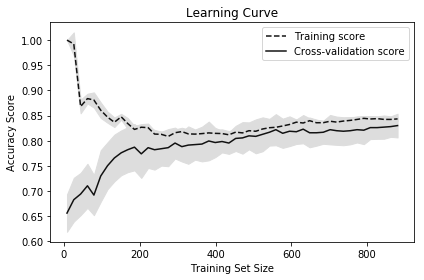

In [70]:
train_sizes, train_scores, test_scores = learning_curve(logreg, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [71]:
y_pred = logreg.predict(X_test)


array([[68, 21],
       [16, 91]], dtype=int64)

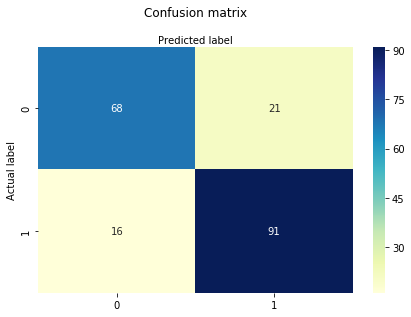

In [72]:
utils.display_confusion_matrix(y_test, y_pred)

In [73]:
prediction_probabilities = logreg.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.8112244897959183
Precision: 0.8125
Recall: 0.8504672897196262
Log loss=  0.467520188745519


In [74]:
scores = cross_val_score(logreg, X,y, cv=10, scoring='accuracy')
print(scores.mean())

0.8302440563854407


#### Model Feature Optimization

In [75]:
model_stats = eliminate_features_logistic_regression(logreg, X,y)

Iteration=  0
least_important label=  win_pts
Iteration=  1
least_important label=  lose_pts
Iteration=  2
least_important label=  delta_ft_pct
Iteration=  3
least_important label=  delta_rpi
Iteration=  4
least_important label=  top_conf_o
Iteration=  5
least_important label=  delta_def_rebs_avg
Iteration=  6
least_important label=  delta_to_net_avg
Iteration=  7
least_important label=  delta_fg_pct
Iteration=  8
least_important label=  delta_off_rebs_avg
Iteration=  9
least_important label=  delta_off_rating
Iteration=  10
least_important label=  delta_ft_att_avg
Iteration=  11
least_important label=  top_conf_t
Iteration=  12
least_important label=  delta_sag
Iteration=  13
least_important label=  delta_pom
Iteration=  14
least_important label=  delta_wlk
Iteration=  15
least_important label=  delta_mor
Iteration=  16
least_important label=  delta_wol
Iteration=  17
least_important label=  delta_margin_victory_avg
Iteration=  18
least_important label=  delta_rth
Iteration=  19
least

In [76]:
max_accuracy = 0
max_cross_val = 0
min_log_loss = 10000
for key, value in model_stats.items():
    accuracy = value['accuracy']
    cross_val = value['cross_validation']
    log_loss_val = value['log_loss']
    print('Accuracy= {0:6.4f} Cross Val= {1:6.4f}  Log Loss= {2:6.4f}'.format(accuracy ,cross_val, log_loss_val ))
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        accuracy_hash = key
    if cross_val > max_cross_val:
        max_cross_val = cross_val
        cross_hash = key
    if log_loss_val < min_log_loss:
        min_log_loss = log_loss_val
        log_hash = key

print("\n")

print('Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['accuracy']))
print('Max Cross Validation= {0:6.4f}'.format( model_stats[cross_hash]['cross_validation']))
print ("Minimum Log Loss= {0:6.4f}".format(  model_stats[log_hash]['log_loss']))
print('Log Loss at Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['log_loss'] ))
print('Log Loss at Max Cross Validation= {0:6.4f} '.format( model_stats[cross_hash]['log_loss'] ))

Accuracy= 0.8112 Cross Val= 0.8302  Log Loss= 0.4675
Accuracy= 0.8112 Cross Val= 0.8292  Log Loss= 0.4674
Accuracy= 0.7959 Cross Val= 0.8344  Log Loss= 0.4658
Accuracy= 0.7959 Cross Val= 0.8364  Log Loss= 0.4659
Accuracy= 0.7959 Cross Val= 0.8385  Log Loss= 0.4660
Accuracy= 0.8010 Cross Val= 0.8354  Log Loss= 0.4663
Accuracy= 0.7959 Cross Val= 0.8364  Log Loss= 0.4663
Accuracy= 0.7959 Cross Val= 0.8344  Log Loss= 0.4669
Accuracy= 0.7908 Cross Val= 0.8323  Log Loss= 0.4661
Accuracy= 0.7908 Cross Val= 0.8344  Log Loss= 0.4646
Accuracy= 0.8010 Cross Val= 0.8364  Log Loss= 0.4652
Accuracy= 0.7857 Cross Val= 0.8323  Log Loss= 0.4688
Accuracy= 0.7959 Cross Val= 0.8375  Log Loss= 0.4687
Accuracy= 0.7959 Cross Val= 0.8375  Log Loss= 0.4686
Accuracy= 0.7959 Cross Val= 0.8395  Log Loss= 0.4687
Accuracy= 0.7959 Cross Val= 0.8323  Log Loss= 0.4713
Accuracy= 0.7959 Cross Val= 0.8343  Log Loss= 0.4723
Accuracy= 0.7857 Cross Val= 0.8292  Log Loss= 0.4787
Accuracy= 0.7806 Cross Val= 0.8272  Log Loss= 

In [77]:
model_features = model_stats[cross_hash]['labels']
print(model_features)

['delta_margin_victory_avg', 'delta_win_pct', 'delta_seed', 'delta_srs', 'delta_sos', 'delta_wlk', 'delta_wol', 'delta_rth', 'delta_col', 'delta_dol', 'delta_mor']


In [78]:
X=X[model_features]

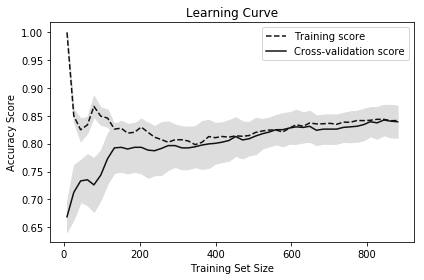

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
logreg.fit(X_train, y_train)


train_sizes, train_scores, test_scores = learning_curve(logreg, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [80]:
utils.display_important_features(logreg.coef_[0], X_train,1)

Coefficient Values
delta_win_pct   3.5055094665480917
delta_sos   3.2290710652161723
delta_srs   2.4531205501337325
delta_col   2.402543471816486
delta_dol   1.7542760022772246
delta_seed   1.3363419849660065
delta_rth   0.91075570399074
delta_margin_victory_avg   -0.8803613918049641
delta_wol   -0.8284314866333673
delta_mor   -0.3866882124545956
delta_wlk   -0.32882066842694546


[('delta_win_pct', 3.5055094665480917),
 ('delta_sos', 3.2290710652161723),
 ('delta_srs', 2.4531205501337325),
 ('delta_col', 2.402543471816486),
 ('delta_dol', 1.7542760022772246),
 ('delta_seed', 1.3363419849660065),
 ('delta_rth', 0.91075570399074),
 ('delta_margin_victory_avg', -0.8803613918049641),
 ('delta_wol', -0.8284314866333673),
 ('delta_mor', -0.3866882124545956),
 ('delta_wlk', -0.32882066842694546)]

Accuracy: 0.7959183673469388
Precision: 0.7964601769911505
Recall: 0.8411214953271028
Log loss=  0.46867236558190517


array([[66, 23],
       [17, 90]], dtype=int64)

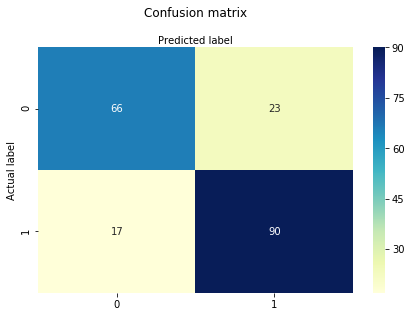

In [81]:
y_pred = logreg.predict(X_test)
# save model stats
prediction_probabilities = logreg.predict_proba(X_test)

cross_val_scores = cross_val_score(logreg, X,y, cv=10, scoring='accuracy')
cross_validation_average = cross_val_scores.mean()

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

utils.display_confusion_matrix(y_test, y_pred)

In [82]:
scores = cross_val_score(logreg, X,y, cv=10, scoring='accuracy')
print("Cross Validation: ", scores.mean())

Cross Validation:  0.8394803282137596


In [83]:
def get_missed_predictions(tourney_comp_ratings, numeric_feature_to_scale, prediction_probabilities, X, y, y_pred):
    
    pred_probs = pd.Series(prediction_probabilities[:,1], index=X.index)
    predictions = pd.Series(y_pred, index=y.index)
    test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X.index)].copy()
    test_games[numeric_feature_to_scale] = scaler.inverse_transform(test_games[numeric_feature_to_scale])
    test_games['predicted_result'] = predictions
    test_games['pred_win_prob'] = pred_probs
    missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)
   
    missed_predictions.apply(lambda x: feature_dictionary.print_game_info(test_games,x['season_t'], x['round'], x['team_t'] ), axis=1)
    supporting_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row,
                                                                                         feature_dictionary, 
                                                                                         feature_list),axis=1)

    supporting_model_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, 
                                                                                               feature_dictionary,
                                                                                               model_features),axis=1)
    
    missed_predictions = missed_predictions.merge(supporting_features.to_frame(name='supporting_features'),how='left',
                                              left_index=True, right_index=True)

    missed_predictions = missed_predictions.merge(supporting_model_features.to_frame(name='supporting_model_features'),how='left', 
                                              left_index=True, right_index=True)

    missed_predictions['features'] = 100 * missed_predictions['supporting_features'].apply(lambda x: len(x)) / len(feature_list)

    missed_predictions['model_features'] = 100 * missed_predictions['supporting_model_features'].apply(lambda x: len(x)) / \
        len(model_features)

    missed_predictions['game_index'] = missed_predictions.index
    
    return missed_predictions

In [84]:
missed_predictions = get_missed_predictions(tourney_comp_ratings, numeric_feature_to_scale, 
                                            prediction_probabilities, X_test, y_test, y_pred)


                                       Kansas                   Bucknell     Stat Supports Winner
Allow PPG                       65.00                              58.00         True  (L)
FT %                            69.50                              70.10         True  (H)
Takeaway Avg                     6.00                               7.00         True  (H)
Seed                              3                                 14          False  (L)
SAG                              9.00                             114.00        False  (L)
WLK                              7.00                              97.00        False  (L)
WOL                             10.00                              84.00        False  (L)
RTH                              7.00                             137.00        False  (L)
COL                              4.00                             102.00        False  (L)
POM                             12.00                             110.00        Fal

SOS                             10.86                               7.77        False  (H)
PPG                             79.00                              78.00        False  (H)
FT ATT Avg                      24.00                              21.00        False  (H)
FT %                            73.60                              62.30        False  (H)
Takeaway Avg                     9.00                               5.00        False  (H)
Off Rating                      96.53                              93.14        False  (H)

 Connecticut Wins.

Supporting Stat Count= 7  out of 26  stats.



                                   Pittsburgh                  Villanova     Stat Supports Winner
SOS                              8.61                               8.72         True  (H)
Poss Avg                        80.42                              80.67         True  (H)
FT ATT Avg                      19.00                              24.00         True  (H)
FT %           

In [85]:
missed_predictions

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob,supporting_features,supporting_model_features,features,model_features,game_index
128,2005,64,2005-03-18 00:00:00.0000000,3,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,64,14,Bucknell,98d2123a-c7b9-4b5f-8a81-43f76d8537dc,63,-1,2004,Lose,20.68,10.85,0.767,75.0,65.0,0.476,0.695,79.220000,11.0,25.0,14.0,6.0,94.673062,21.0,2.12,-2.19,0.697,63.0,58.0,0.444,0.701,71.569697,9.0,22.0,15.0,7.0,88.026082,20.0,Big 12,Patriot League,9,7.0,10,7,4.0,12.0,8.0,1.0,19,114,97.0,84,137,102.0,110.0,87.0,64.0,151,1,0,1,10.0,5.0,5.000000e+00,0.032,2.0,3.0,-0.006,8.0,8.0,0.0,0.070,6.646981,1.0,-1.100000e+01,18.56,13.04,-105.0,-90.0,-74.0,-130.0,-98.0,-98.0,-79.0,-63.0,-132.0,1,0.980015,[ft_pct],[],4.0,0.000000,128
816,2015,32,2015-03-21 00:00:00.0000000,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,71,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,68,-1,2014,Lose,23.13,7.55,0.917,76.0,60.0,0.470,0.731,73.861111,10.0,24.0,10.0,7.0,102.895825,22.0,14.11,9.72,0.611,70.0,65.0,0.436,0.686,75.550000,12.0,25.0,10.0,3.0,92.653872,20.0,Big East,Atlantic Coast,6,4.0,2,2,2.0,5.0,2.0,2.0,4,32,33.0,40,32,40.0,38.0,40.0,39.0,22,0,0,1,16.0,5.0,1.100000e+01,0.034,-2.0,-1.0,0.045,3.0,7.0,-4.0,0.306,10.241954,2.0,-7.000000e+00,9.02,-2.17,-26.0,-29.0,-38.0,-30.0,-38.0,-33.0,-38.0,-37.0,-18.0,1,0.979165,"[off_rebs_avg, def_rebs_avg, sos]",[sos],12.0,9.090909,816
178,2005,32,2005-03-19 00:00:00.0000000,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,111,7,West Virginia,f770d3a2-221c-49ce-9c7a-680f7417fe9e,105,-1,2004,Lose,20.24,10.27,0.818,84.0,73.0,0.491,0.684,85.224242,14.0,25.0,14.0,8.0,98.563504,27.0,11.76,7.62,0.686,71.0,67.0,0.450,0.742,73.782857,9.0,20.0,11.0,8.0,96.228315,17.0,Atlantic Coast,Big 12,4,4.0,3,4,6.0,5.0,3.0,7.0,5,38,39.0,28,32,34.0,35.0,30.0,34.0,30,0,0,0,11.0,4.0,7.000000e+00,0.041,5.0,5.0,-0.058,6.0,3.0,3.0,0.132,2.335190,10.0,-5.000000e+00,8.48,2.65,-34.0,-35.0,-25.0,-28.0,-28.0,-30.0,-27.0,-27.0,-25.0,1,0.956262,"[ft_pct, to_net_avg]",[],8.0,0.000000,178
778,2014,64,2014-03-21 00:00:00.0000000,3,Duke,faeb1160-5d15-4f26-99fc-c441cf21fc7f,78,14,Mercer,a14b0057-8eb5-43d2-a33b-666196da933e,71,-1,2013,Lose,19.51,8.48,0.743,78.0,67.0,0.460,0.729,76.034286,11.0,22.0,9.0,6.0,102.585300,22.0,5.33,-3.42,0.750,78.0,66.0,0.476,0.736,77.705556,11.0,25.0,11.0,5.0,100.378923,21.0,Atlantic Coast,Southern,7,8.0,15,9,14.0,6.0,14.0,9.0,8,89,97.0,90,124,93.0,95.0,100.0,81.0,94,1,0,1,11.0,12.0,-1.000000e+00,-0.016,0.0,-3.0,-0.007,3.0,6.0,-3.0,-0.007,2.206377,1.0,-1.100000e+01,14.18,11.90,-82.0,-89.0,-75.0,-115.0,-79.0,-89.0,-86.0,-72.0,-86.0,1,0.856420,"[margin_victory_avg, fg_pct, def_rebs_avg, ft_...","[margin_victory_avg, win_pct]",20.0,18.181818,778
852,2016,64,2016-03-18 00:00:00.0000000,3,West Virginia,f770d3a2-221c-49ce-9c7a-680f7417fe9e,70,14,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,56,-1,2015,Lose,21.61,9.78,0.743,78.0,66.0,0.449,0.673,85.394286,15.0,23.0,14.0,9.0,91.341006,27.0,9.23,-5.47,0.824,80.0,63.0,0.478,0.735,80.100000,11.0,23.0,12.0,9.0,99.875156,20.0,Big 

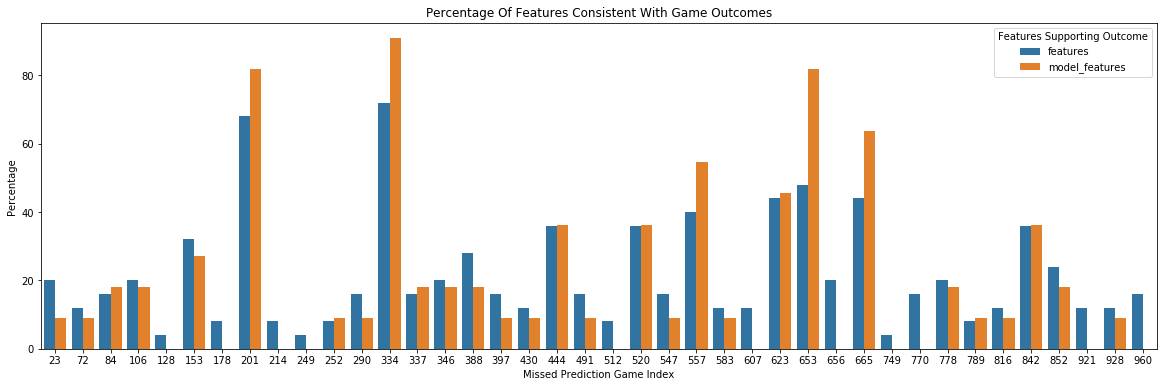

In [87]:
plot_missed_predictions_df = missed_predictions[['game_index','features','model_features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('Missed Prediction Game Index')
m_plot.figure.set_size_inches(20,6)

##### The bar chart depicts the percentage of features that correctly corresponded to the game outcome but were out weighed by other features in predicting the game incorrectly. Games corresponding to bar heights exceeding 50% should be scrutinized.

### Run Model Against 2018 Tournament

In [89]:
test_year = 2018
X_season = feature_data[feature_data['season_t']== test_year][model_features]
y_season = tourney_comp_ratings[tourney_comp_ratings['season_t']== test_year]['game_result']
X_season.shape

(67, 11)

array([[28,  5],
       [ 5, 29]], dtype=int64)

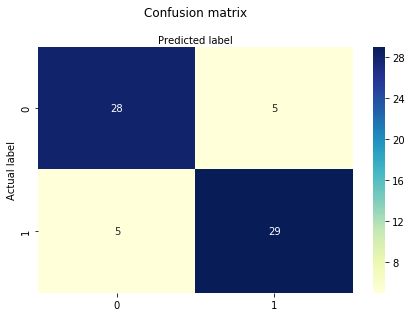

In [90]:
y_pred_season = logreg.predict(X_season)
utils.display_confusion_matrix(y_season,y_pred_season)



In [91]:
prediction_probabilities = logreg.predict_proba(X_season)
print("Accuracy:",metrics.accuracy_score(y_season, y_pred_season))
print("Precision:", metrics.precision_score(y_season,y_pred_season))
print("Recall:",metrics.recall_score(y_season, y_pred_season))
print("Log loss= ",log_loss(y_season, prediction_probabilities))

Accuracy: 0.8507462686567164
Precision: 0.8529411764705882
Recall: 0.8529411764705882
Log loss=  0.43208447914407877


In [92]:
missed_predictions = get_missed_predictions(tourney_comp_ratings, numeric_feature_to_scale, 
                                            prediction_probabilities,X_season,y_season,y_pred_season)

                               North Carolina                  Texas A&M     Stat Supports Winner
Allow PPG                       73.00                              70.00         True  (L)
FG %                            45.70                              46.00         True  (H)
Def Rb Avg                      28.00                              29.00         True  (H)
FT ATT Avg                      18.00                              19.00         True  (H)
Seed                              2                                  7          False  (L)
SAG                              8.00                              27.00        False  (L)
WLK                              7.00                              28.00        False  (L)
WOL                              8.00                              29.00        False  (L)
RTH                              9.00                              27.00        False  (L)
COL                              9.00                              27.00        Fal

In [93]:
missed_predictions

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob,supporting_features,supporting_model_features,features,model_features,game_index
1022,2018,32,2018-03-01 00:00:00.0000000,2,North Carolina,e9ca48b2-00ba-41c0-a02b-6885a2da1ff1,86,7,Texas A&M,ef184799-d79b-49d9-a662-991eaf4044cd,65,-1,2017,Lose,20.08,11.78,0.703,81.0,73.0,0.457,0.743,84.670270,13.0,28.0,12.0,5.0,95.665220,18.0,15.30,10.62,0.629,75.0,70.0,0.460,0.661,81.960000,12.0,29.0,13.0,5.0,91.508053,19.0,Atlantic Coast,Southeastern,8,7.0,8,9,9.0,7.0,10.0,4.0,7,27,28.0,29,27,27.0,30.0,28.0,29.0,28,0,0,0,8.0,5.0,3.0,-0.003,1.0,-1.0,0.082,7.0,8.0,-1.0,0.074,4.157167,-1.0,-5.0,4.78,1.16,-19.0,-21.0,-21.0,-18.0,-18.0,-23.0,-18.0,-25.0,-21.0,1,0.781541,"[fg_pct, def_rebs_avg, ft_att_avg]",[],12.0,0.000000,1022
988,2018,64,2018-03-01 00:00:00.0000000,4,Arizona,9b166a3f-e64b-4825-bb6b-92c6f0418263,89,13,Buffalo,a9f5c9a2-342c-4881-9996-5d5c05ec9bd9,68,-1,2017,Lose,15.67,6.84,0.771,80.0,71.0,0.504,0.760,77.868571,10.0,26.0,12.0,4.0,102.737213,21.0,7.99,0.25,0.750,84.0,76.0,0.473,0.699,84.944444,11.0,26.0,12.0,6.0,98.888162,19.0,Pacific 12,Mid-American,16,19.0,19,20,11.0,21.0,19.0,13.0,15,73,68.0,55,79,43.0,76.0,72.0,25.0,78,1,0,1,9.0,8.0,1.0,0.031,-1.0,0.0,0.061,8.0,6.0,2.0,0.021,3.849051,2.0,-9.0,7.68,6.59,-57.0,-49.0,-36.0,-59.0,-32.0,-55.0,-53.0,-12.0,-63.0,1,0.774116,"[off_rebs_avg, to_net_avg]",[],8.0,0.000000,988
1038,2018,16,2018-03-01 00:00:00.0000000,2,Purdue,12d7f888-675b-459f-9099-a38f771d8a95,78,3,Texas Tech,f8c705b7-87d3-411a-9c8b-5124daab0469,65,-1,2017,Lose,23.41,8.74,0.811,80.0,65.0,0.493,0.743,75.535135,8.0,26.0,10.0,5.0,105.910978,20.0,19.38,9.60,0.730,74.0,64.0,0.460,0.704,77.816216,10.0,25.0,12.0,7.0,95.095860,22.0,Big Ten,Big 12,5,4.0,9,8,10.0,5.0,5.0,9.0,4,13,13.0,18,14,19.0,12.0,14.0,23.0,10,0,0,0,15.0,10.0,5.0,0.033,-2.0,1.0,0.039,5.0,5.0,0.0,0.081,10.815118,-2.0,-1.0,4.03,-0.86,-8.0,-9.0,-9.0,-6.0,-9.0,-7.0,-9.0,-14.0,-6.0,1,0.771017,"[off_rebs_avg, ft_att_avg, sos]",[sos],12.0,9.090909,1038
1024,2018,32,2018-03-01 00:00:00.0000000,5,Ohio St,857462b3-0ab6-4d26-9669-10ca354e382b,90,4,Gonzaga,2f4d21f8-6d5f-48a5-abca-52a30583871a,84,-1,2017,Lose,17.67,9.03,0.735,76.0,67.0,0.480,0.731,77.217647,9.0,26.0,11.0,6.0,98.423097,18.0,18.43,2.59,0.865,83.0,67.0,0.498,0.708,80.297297,10.0,28.0,11.0,6.0,103.365870,19.0,Big Ten,West Coast,22,16.0,21,19,18.0,15.0,13.0,20.0,16,10,11.0,10,11,17.0,8.0,12.0,21.0,11,1,0,0,9.0,16.0,-7.0,-0.018,-1.0,-2.0,0.023,5.0,5.0,0.0,-0.130,-4.942773,-1.0,1.0,-0.76,6.44,12.0,5.0,11.0,8.0,1.0,7.0,1.0,-1.0,5.0,1,0.669794,"[margin_victory_avg, fg_pct, off_rebs_avg, def...","[margin_victory_avg, win_pct, seed, srs, wlk, ...",68.0,90.909091,1024
1004,2018,64,2018-03-01 00:00:00.0000000,4,Wichita St,f38b58de-3273-4723-a78b-2f918e9aa2d5,81,13,Marshall,58d8baa3-7624-4b21-a47f-a23df2bf8859,75,-1,2017,Lose,16.58,5.46,0.758,82.0,71.0,0.476,0.739,81.030303,12.0,28.0,11.0,4.0,101.196709,21.0,4.21,0.44,0.694,83.0,79.0,0.467,0.764,83.522222,8.0,27.0,13.0,7.0,99.374751,20.0,American Athletic,Conference USA,15,21.0,14,17,14.0,20.0,20.0,16.0,18,125

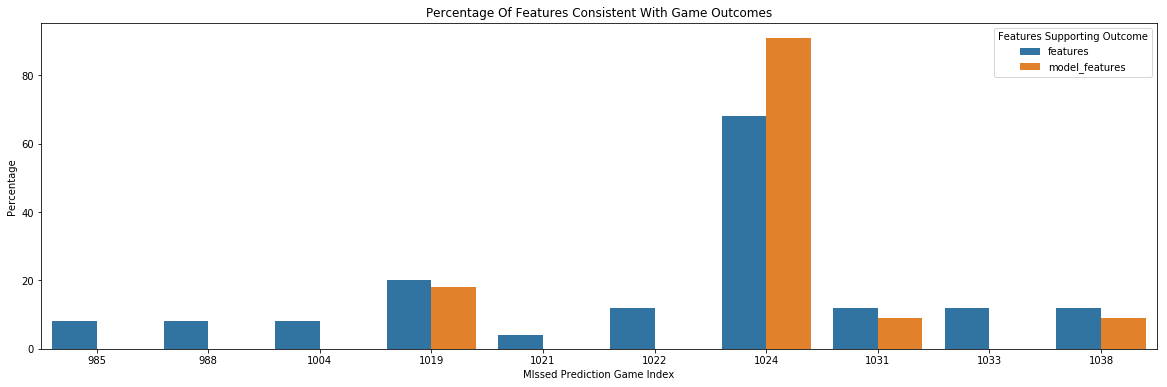

In [94]:
plot_missed_predictions_df = missed_predictions[['game_index','features','model_features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('MIssed Prediction Game Index')
m_plot.figure.set_size_inches(20,6)